In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from scipy import stats
from scipy import constants as con
import pandas as pd
from scipy.signal import savgol_filter

<>:62: SyntaxWarning: invalid escape sequence '\l'
<>:62: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Anwender\AppData\Local\Temp\ipykernel_20884\1873610822.py:62: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_title("scaled by function linear in $\lambda$")
C:\Users\Anwender\AppData\Local\Temp\ipykernel_20884\1873610822.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  transmission.append(float(nd[1][np.argwhere(nd[0]==wl)][0]))


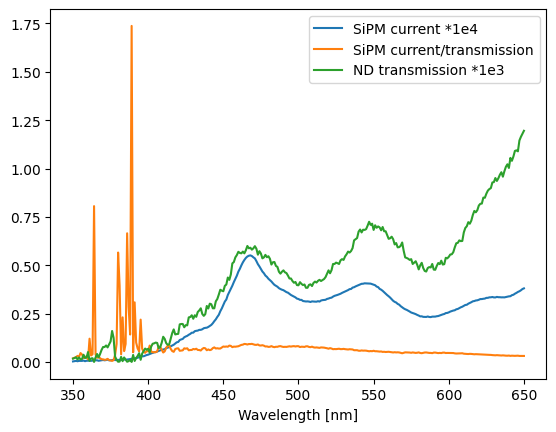

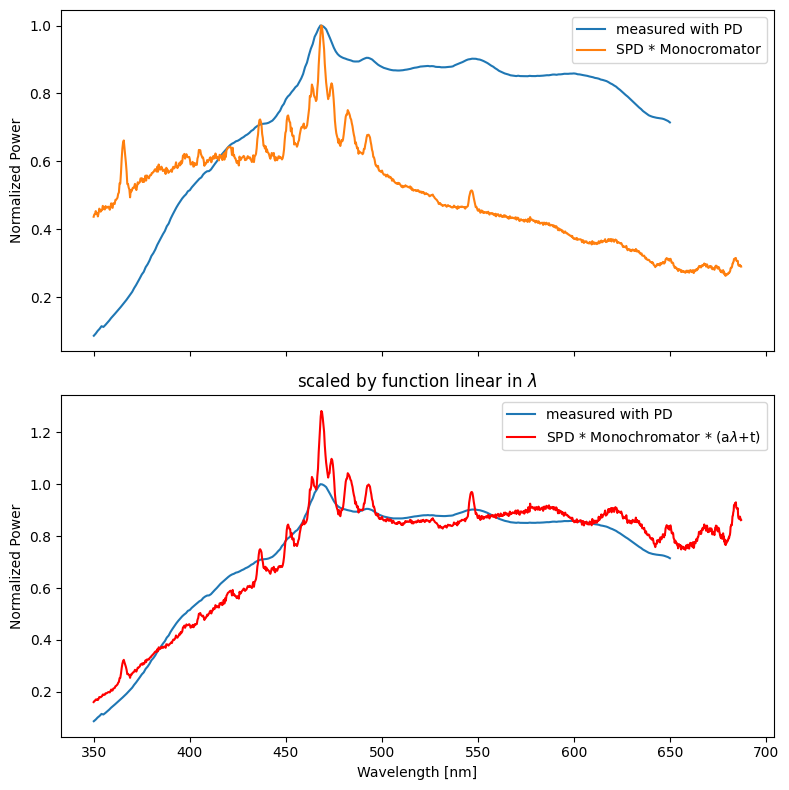

In [6]:
#Import data from measurement and remove dark current
wavelength=np.arange(350,651,1)
nist=-np.array([-1.954024e-07, -2.0941635e-07, -2.266921e-07, -2.3987385e-07, -2.5668025e-07, -2.5142275e-07, -2.6336045e-07, -2.769191e-07, -2.9032635e-07, -3.0597405e-07, -3.1873144999999996e-07, -3.324593e-07, -3.463463e-07, -3.5924165e-07, -3.742004e-07, -3.888952e-07, -4.0496325e-07, -4.2165120000000003e-07, -4.3992265e-07, -4.5929535e-07, -4.765969e-07, -5.036491499999999e-07, -5.2709465e-07, -5.5322545e-07, -5.804615500000001e-07, -6.088943000000001e-07, -6.3212545e-07, -6.694945e-07, -6.9533645e-07, -7.274536000000001e-07, -7.661561999999999e-07, -7.9300955e-07, -8.252592e-07, -8.652238499999999e-07, -8.988115999999999e-07, -9.3290995e-07, -9.674252e-07, -9.985823e-07, -1.0413909999999999e-06, -1.070568e-06, -1.115487e-06, -1.152994e-06, -1.1886864999999999e-06, -1.2254345e-06, -1.2586505e-06, -1.289328e-06, -1.3206635e-06, -1.3470824999999998e-06, -1.37061e-06, -1.4033535e-06, -1.4209249999999999e-06, -1.4516915e-06, -1.4771615000000001e-06, -1.5041749999999999e-06, -1.5304709999999998e-06, -1.5563685000000001e-06, -1.5758374999999999e-06, -1.6088775e-06, -1.632905e-06, -1.652177e-06, -1.661849e-06, -1.6835870000000001e-06, -1.715247e-06, -1.7467605e-06, -1.7768875e-06, -1.8095645e-06, -1.8426314999999999e-06, -1.8703449999999999e-06, -1.896856e-06, -1.926489e-06, -1.9544515e-06, -1.9800575000000003e-06, -2.001238e-06, -2.018119e-06, -2.0395575e-06, -2.053679e-06, -2.072305e-06, -2.0936410000000002e-06, -2.111678e-06, -2.134369e-06, -2.1525430000000003e-06, -2.1747735e-06, -2.2013094999999997e-06, -2.220428e-06, -2.2490085e-06, -2.270986e-06, -2.2891555e-06, -2.3069825e-06, -2.3184465e-06, -2.3287789999999997e-06, -2.339733e-06, -2.3536419999999997e-06, -2.3728245e-06, -2.3910995e-06, -2.4202135000000004e-06, -2.4521025e-06, -2.489363e-06, -2.5217565e-06, -2.5727114999999997e-06, -2.6068969999999997e-06, -2.6599555e-06, -2.696403e-06, -2.723407e-06, -2.7599345e-06, -2.7918575e-06, -2.8277375e-06, -2.85295e-06, -2.8968725e-06, -2.942666e-06, -2.9978255e-06, -3.0776309999999998e-06, -3.132621e-06, -3.2189135e-06, -3.2952125000000003e-06, -3.354672e-06, -3.440325e-06, -3.489803e-06, -3.5470305e-06, -3.5905005000000003e-06, -3.5973015e-06, -3.5931560000000002e-06, -3.5825475e-06, -3.5474110000000002e-06, -3.509432e-06, -3.4683399999999997e-06, -3.4281595e-06, -3.397091e-06, -3.377471e-06, -3.367163e-06, -3.363966e-06, -3.363262e-06, -3.3656665e-06, -3.3661285e-06, -3.369483e-06, -3.3718310000000003e-06, -3.371796e-06, -3.378501e-06, -3.388079e-06, -3.396925e-06, -3.4166304999999997e-06, -3.4378679999999997e-06, -3.4563600000000002e-06, -3.4732905e-06, -3.4811874999999998e-06, -3.481475e-06, -3.4790715e-06, -3.4674665000000003e-06, -3.4584835e-06, -3.4477875000000002e-06, -3.4426949999999997e-06, -3.439987e-06, -3.437487e-06, -3.4394065e-06, -3.4424705e-06, -3.4434765e-06, -3.447007e-06, -3.4518179999999998e-06, -3.459915e-06, -3.466492e-06, -3.474536e-06, -3.4851510000000002e-06, -3.495083e-06, -3.508124e-06, -3.5193655000000003e-06, -3.532676e-06, -3.545355e-06, -3.5607645000000003e-06, -3.5743325e-06, -3.5854109999999997e-06, -3.5984125e-06, -3.613018e-06, -3.623499e-06, -3.634804e-06, -3.643284e-06, -3.654775e-06, -3.6594295e-06, -3.6697895e-06, -3.6763230000000003e-06, -3.677978e-06, -3.6848675000000003e-06, -3.693162e-06, -3.6971590000000003e-06, -3.7057690000000004e-06, -3.713956e-06, -3.7251619999999997e-06, -3.7354684999999997e-06, -3.745493e-06, -3.7582440000000002e-06, -3.780625e-06, -3.7993e-06, -3.817698e-06, -3.8355435e-06, -3.8534635e-06, -3.8739764999999996e-06, -3.895172499999999e-06, -3.912647e-06, -3.924682000000001e-06, -3.93891e-06, -3.946532e-06, -3.9542175e-06, -3.9559225e-06, -3.9608035e-06, -3.959952e-06, -3.957510499999999e-06, -3.9529335e-06, -3.947838e-06, -3.938374e-06, -3.929928e-06, -3.924915e-06, -3.9130965e-06, -3.9059510000000005e-06, -3.8948475e-06, -3.890732000000001e-06, -3.8862539999999995e-06, -3.883017e-06, -3.8837845e-06, -3.884036e-06, -3.8822295e-06, -3.8867525e-06, -3.890923999999999e-06, -3.8956195000000005e-06, -3.9082230000000005e-06, -3.911037999999999e-06, -3.917478e-06, -3.925336499999999e-06, -3.9334055e-06, -3.9402465000000005e-06, -3.95312e-06, -3.958237e-06, -3.966219e-06, -3.973639e-06, -3.984607e-06, -3.9910040000000005e-06, -3.9996885e-06, -4.009463e-06, -4.020023e-06, -4.030819000000001e-06, -4.0380225e-06, -4.0511905e-06, -4.063848499999999e-06, -4.0721165e-06, -4.0765365000000005e-06, -4.089899e-06, -4.0980615e-06, -4.108788500000001e-06, -4.121679e-06, -4.128798499999999e-06, -4.1358465e-06, -4.1462205000000005e-06, -4.1540285e-06, -4.1640355e-06, -4.168090500000001e-06, -4.167453e-06, -4.1733375000000004e-06, -4.1750155e-06, -4.177559999999999e-06, -4.1803035e-06, -4.18304e-06, -4.182775e-06, -4.184195e-06, -4.185878e-06, -4.1837395e-06, -4.186807500000001e-06, -4.1871219999999994e-06, -4.1820135e-06, -4.1836375e-06, -4.182815500000001e-06, -4.181136e-06, -4.173549e-06, -4.1626945e-06, -4.1565185000000005e-06, -4.1449785e-06, -4.135645e-06, -4.11736e-06, -4.103281e-06, -4.084555e-06, -4.06754e-06, -4.0468145e-06, -4.030688e-06, -4.010365e-06, -3.9914125e-06, -3.9711375e-06, -3.9472295e-06, -3.9268775e-06, -3.906982e-06, -3.890422e-06, -3.8666960000000005e-06, -3.8516165e-06, -3.834878e-06, -3.821480500000001e-06, -3.8150715e-06, -3.810851e-06, -3.8092695e-06, -3.8094295e-06, -3.811511e-06, -3.8148515e-06, -3.8149305e-06, -3.8128145e-06, -3.806397e-06, -3.798508e-06, -3.782469e-06])
sipm=np.array([2.1267105e-06, 2.2430425e-06, 2.4075565e-06, 2.220715e-06, 2.413295e-06, 2.4252805000000003e-06, 2.399144e-06, 2.5871065e-06, 2.24029e-06, 2.4863605e-06, 2.510816e-06, 2.4967610000000004e-06, 2.4235055e-06, 2.5875645e-06, 2.5765375e-06, 2.7144415e-06, 2.7041275e-06, 2.450815e-06, 2.608427e-06, 2.711015e-06, 2.8718575e-06, 2.7099400000000003e-06, 2.8298185e-06, 3.0560805000000003e-06, 2.7042225e-06, 2.7049189999999996e-06, 2.7842315e-06, 3.006224e-06, 2.8155645e-06, 2.896837e-06, 2.9027735e-06, 2.956392e-06, 2.8605875e-06, 2.9272945e-06, 3.1355760000000003e-06, 2.989804e-06, 3.1017594999999997e-06, 3.1957815e-06, 3.3383504999999997e-06, 3.5074985e-06, 3.6545965e-06, 3.62382e-06, 3.8885115e-06, 4.016239e-06, 4.337077999999999e-06, 4.405137000000001e-06, 4.8192669999999995e-06, 4.793749e-06, 5.134388e-06, 5.4323125e-06, 5.61836e-06, 5.9644885000000004e-06, 6.263855e-06, 6.537848e-06, 6.800722e-06, 6.950879000000001e-06, 7.259257e-06, 7.522034e-06, 7.834508999999999e-06, 8.135767499999999e-06, 8.268107e-06, 8.4467715e-06, 9.063069e-06, 9.2349955e-06, 9.563719500000001e-06, 9.971413999999999e-06, 1.0339805e-05, 1.0746230000000001e-05, 1.1400065e-05, 1.1996215e-05, 1.2178945e-05, 1.3178555e-05, 1.349565e-05, 1.37474e-05, 1.4601770000000001e-05, 1.5011585e-05, 1.5342575e-05, 1.5900325e-05, 1.633302e-05, 1.6963175e-05, 1.6983975e-05, 1.7745015e-05, 1.794029e-05, 1.8053825e-05, 1.8433199999999998e-05, 1.844631e-05, 1.873426e-05, 1.927044e-05, 1.9465175e-05, 1.955299e-05, 1.993767e-05, 2.0446165e-05, 2.097988e-05, 2.184698e-05, 2.2923840000000002e-05, 2.386928e-05, 2.5124240000000002e-05, 2.621182e-05, 2.807218e-05, 2.9517765e-05, 3.129909e-05, 3.3053274999999996e-05, 3.412577e-05, 3.6461575e-05, 3.806885e-05, 3.9712640000000006e-05, 4.125003e-05, 4.3124595e-05, 4.4818025e-05, 4.6426815e-05, 4.8497e-05, 4.9969525e-05, 5.1739085e-05, 5.3298980000000004e-05, 5.4550074999999996e-05, 5.5601860000000004e-05, 5.6329025e-05, 5.6733745000000005e-05, 5.690395e-05, 5.656887e-05, 5.591034e-05, 5.5349775e-05, 5.3960485000000005e-05, 5.2381875e-05, 5.1223415e-05, 4.9856015e-05, 4.8570595e-05, 4.7688855e-05, 4.6491715e-05, 4.581318e-05, 4.4829214999999995e-05, 4.4122345e-05, 4.3422815e-05, 4.249934e-05, 4.1689044999999997e-05, 4.1184475000000003e-05, 4.0716035000000004e-05, 3.9976965e-05, 3.9536795000000004e-05, 3.9176665000000005e-05, 3.892563e-05, 3.8429504999999996e-05, 3.792856e-05, 3.7645315e-05, 3.7070864999999995e-05, 3.645118e-05, 3.604092e-05, 3.5609724999999994e-05, 3.5205480000000006e-05, 3.4566285e-05, 3.4379855e-05, 3.3918945e-05, 3.393056e-05, 3.3335855000000004e-05, 3.321559e-05, 3.3094425e-05, 3.3147655e-05, 3.3045795e-05, 3.2833185e-05, 3.313995e-05, 3.305855e-05, 3.301465e-05, 3.2987885e-05, 3.3254505e-05, 3.3028775e-05, 3.3588365e-05, 3.378962e-05, 3.3901515e-05, 3.3964505000000004e-05, 3.4422790000000005e-05, 3.4598545e-05, 3.4918819999999996e-05, 3.5068095e-05, 3.560907e-05, 3.6011390000000005e-05, 3.6249365e-05, 3.6492220000000004e-05, 3.681472e-05, 3.709803e-05, 3.753932e-05, 3.7906005e-05, 3.8330324999999996e-05, 3.861791e-05, 3.8976015e-05, 3.9474905e-05, 3.9553245e-05, 4.0259464999999994e-05, 4.0462955e-05, 4.0890435000000007e-05, 4.1229445000000005e-05, 4.15159e-05, 4.190013e-05, 4.2224995e-05, 4.226691e-05, 4.24769e-05, 4.242296e-05, 4.240062e-05, 4.235953e-05, 4.2319555000000004e-05, 4.2062049999999995e-05, 4.1820825e-05, 4.149142e-05, 4.0794020000000004e-05, 4.0503535e-05, 3.9616209999999996e-05, 3.920191e-05, 3.8599735e-05, 3.786354e-05, 3.7087635e-05, 3.6417125e-05, 3.579509e-05, 3.5096534999999994e-05, 3.430285e-05, 3.3448155e-05, 3.2895675e-05, 3.255147e-05, 3.183894e-05, 3.1455289999999996e-05, 3.0673225e-05, 3.0067970000000002e-05, 2.952743e-05, 2.9076385e-05, 2.8769414999999997e-05, 2.8353355e-05, 2.7886955000000003e-05, 2.7394999999999998e-05, 2.713754e-05, 2.6855495e-05, 2.655733e-05, 2.6153795e-05, 2.5822245e-05, 2.5396795e-05, 2.543263e-05, 2.515339e-05, 2.5145715e-05, 2.5102830000000002e-05, 2.5342514999999998e-05, 2.5091015000000002e-05, 2.5022665e-05, 2.5260820000000002e-05, 2.5269375e-05, 2.5280775000000002e-05, 2.547767e-05, 2.5576465e-05, 2.586934e-05, 2.620974e-05, 2.643139e-05, 2.663075e-05, 2.7097415e-05, 2.718346e-05, 2.7470905000000002e-05, 2.788044e-05, 2.8138205e-05, 2.8406759999999998e-05, 2.856274e-05, 2.9059095e-05, 2.923699e-05, 2.9682335e-05, 3.008733e-05, 3.0391120000000003e-05, 3.0872149999999995e-05, 3.129108e-05, 3.139364e-05, 3.195961e-05, 3.231738e-05, 3.271995e-05, 3.3176795000000004e-05, 3.332674e-05, 3.361419e-05, 3.370729e-05, 3.397954e-05, 3.4342405e-05, 3.43429e-05, 3.449924e-05, 3.4592715e-05, 3.496139e-05, 3.4976315e-05, 3.5232245e-05, 3.5251750000000003e-05, 3.5411705000000006e-05, 3.5200085e-05, 3.5184740000000005e-05, 3.5461390000000005e-05, 3.5313170000000004e-05, 3.5300405e-05, 3.5224095e-05, 3.5251325e-05, 3.5209585e-05, 3.5393695000000006e-05, 3.561416e-05, 3.5745595e-05, 3.580787e-05, 3.63569e-05, 3.6568275e-05, 3.711596e-05, 3.7527235000000005e-05, 3.803112e-05, 3.838055e-05, 3.887938e-05, 3.951485e-05, 3.987349e-05])
nist_dk=2.5162236e-13
sipm_dk=1.7706650000000001e-06
nist-=nist_dk
sipm-=sipm_dk

#Import data from datasheets
nd = np.array(pd.read_csv('transmission_ND.csv', header=None)).transpose()                             #transmission of ND filter
spectral=np.array(pd.read_csv('nist.csv', skiprows=5, encoding='latin1',delimiter=";")).transpose()    #NIST spectral responsivity
xenon=np.array(pd.read_csv('xenon_lamp_output.csv', header=None)).transpose()                          #Xenon Lamp spectral power distribution
mono=np.array(pd.read_csv('mono.csv',sep=";",decimal=",")).transpose()                                 #Monochromator efficiency
transmission=[]
nist_photons=np.interp(wavelength,spectral[0],spectral[1])

plt.plot(wavelength,sipm*1e4, label="SiPM current *1e4")

for wl in wavelength:
    transmission.append(float(nd[1][np.argwhere(nd[0]==wl)][0]))
transmission = np.array(transmission)
sipm/=transmission


plt.plot(wavelength,sipm,label="SiPM current/transmission")
plt.plot(wavelength,transmission*1e3, label="ND transmission *1e3")
plt.xlabel("Wavelength [nm]")
plt.legend()
plt.show()

nist/=np.array(nist_photons)

#Normalize Nist
max_nist=np.max(nist)
nist/=max_nist

mono_interp = np.interp(xenon[0], mono[0], mono[1])
mono_scaled=mono_interp/np.max(mono_interp)*100
xenon_scaled =xenon[1]*mono_scaled 
xenon_wl=xenon[1]*mono_scaled*(0.00751*xenon[0]-2.27)

#Normalize Xenon Lamp
xenon_scaled/=np.max(xenon_scaled)
xenon_wl/=np.max(xenon_wl)*0.78

#Make Plots
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# First subplot: nist and xenon_scaled
axs[0].plot(wavelength, nist, label="measured with PD")
axs[0].plot(xenon[0], xenon_scaled, label="SPD * Monocromator")
axs[0].set_ylabel("Normalized Power")
axs[0].legend()

# Second subplot: nist and xenon_wl
axs[1].plot(wavelength, nist, label="measured with PD")
axs[1].plot(xenon[0], xenon_wl, label="SPD * Monochromator * (a$\\lambda$+t)", color="red")
axs[1].set_xlabel("Wavelength [nm]")
axs[1].set_ylabel("Normalized Power")
axs[1].legend()
axs[1].set_title("scaled by function linear in $\lambda$")

plt.tight_layout()
plt.show()


In [ ]:
#sipm1=np.array([4.262345499999999e-06, 4.6516180000000006e-06, 5.57041e-06, 7.918716999999999e-06, 1.216526e-05, 1.7060214999999997e-05, 1.262104e-05, 1.301367e-05, 1.4327754999999999e-05, 1.0646574999999999e-05, 1.0308095e-05, 1.2072365e-05, 1.3196675e-05])
#sipm2=np.array([2.9548345e-06, 3.0021045e-06, 3.8846825e-06, 6.2316435000000004e-06, 1.0186795e-05, 1.498693e-05, 1.136417e-05, 1.190262e-05, 1.3173235e-05, 9.7280765e-06, 9.5665085e-06, 1.1455555e-05, 1.2667185e-05])
#nist3=-np.array([-1.7233965e-07, -2.0941115e-07, -2.6494375e-07, -3.2673965000000003e-07, -4.0845155e-07, -5.309128e-07, -6.8406465e-07, -8.487119e-07, -1.029585e-06, -1.2045550000000001e-06, -1.343252e-06, -1.4787425e-06, -1.6120745e-06, -1.7717635e-06, -1.931394e-06, -2.0392419999999998e-06, -2.152635e-06, -2.276224e-06, -2.35967e-06, -2.4785355e-06, -2.704286e-06, -2.8805305e-06, -3.1564185e-06, -3.5443705e-06, -3.685816e-06, -3.511933e-06, -3.4520015e-06, -3.467859e-06, -3.5410060000000002e-06, -3.585865e-06, -3.5476135e-06, -3.56287e-06, -3.5986365e-06, -3.6661765e-06, -3.732712e-06, -3.7830435e-06, -3.8142934999999998e-06, -3.853056e-06, -3.9408215e-06, -4.043513e-06, -4.0872000000000004e-06, -4.07438e-06, -4.031489e-06, -4.00668e-06, -4.0231225e-06, -4.0570565e-06, -4.0987205e-06, -4.148481000000001e-06, -4.200578999999999e-06, -4.246189999999999e-06, -4.288483e-06, -4.3063644999999995e-06, -4.315166e-06, -4.3201065e-06, -4.292868e-06, -4.214362e-06, -4.1189125e-06, -4.009202e-06, -3.932657499999999e-06, -3.932379e-06, -3.900723500000001e-06])
#nist2=-np.array([-2.0095025000000002e-07, -2.4223585e-07, -3.0311455e-07, -3.692179e-07, -4.593515e-07, -5.873381e-07, -7.3921295e-07, -9.109813999999999e-07, -1.0919255e-06, -1.2716955e-06, -1.406331e-06, -1.5434645e-06, -1.677298e-06, -1.827712e-06, -1.990446e-06, -2.1013974999999997e-06, -2.2058045e-06, -2.327239e-06, -2.4043470000000002e-06, -2.521779e-06, -2.7455564999999998e-06, -2.9211489999999997e-06, -3.183256e-06, -3.5748275000000003e-06, -3.7275329999999997e-06, -3.5516394999999997e-06, -3.49193e-06, -3.505154e-06, -3.5728495e-06, -3.6221905e-06, -3.5813775e-06, -3.5928705e-06, -3.6315239999999997e-06, -3.6939415e-06, -3.768029e-06, -3.8164975e-06, -3.8516345e-06, -3.8940955e-06, -3.9842270000000004e-06, -4.078912e-06, -4.1279415e-06, -4.121346e-06, -4.078533e-06, -4.053756e-06, -4.067037e-06, -4.1076825e-06, -4.1513459999999995e-06, -4.1986425e-06, -4.2518905e-06, -4.2475275e-06, -4.2905835e-06, -4.307741e-06, -4.3104695e-06, -4.315009e-06, -4.2871785e-06, -4.213685e-06, -4.1186380000000005e-06, -4.009414e-06, -3.932748e-06, -3.9294405e-06, -3.8932e-06])
#sipm=np.array([2.3830085e-06, 2.4331980000000002e-06, 2.3229535e-06, 2.3739384999999997e-06, 2.543739e-06, 2.4822544999999996e-06, 2.706063e-06, 2.8681645000000003e-06, 3.082887e-06, 3.940956499999999e-06, 5.2517615e-06, 6.531747e-06, 7.710482000000001e-06, 9.690480500000001e-06, 1.217229e-05, 1.5219195e-05, 1.757364e-05, 1.8836265e-05, 2.0642850000000002e-05, 2.4789685e-05, 3.2575665000000005e-05, 4.20765e-05, 5.1629954999999996e-05, 5.937102e-05, 5.950107e-05, 5.2604345000000004e-05, 4.7096595e-05, 4.3441355e-05, 4.081301e-05, 3.8766675e-05, 3.6006365e-05, 3.481356e-05, 3.4709255e-05, 3.522339e-05, 3.638996e-05, 3.8119259999999997e-05, 4.0114235e-05, 4.1979955000000005e-05, 4.4311240000000006e-05, 4.508489e-05, 4.406563e-05, 4.13628e-05, 3.7689945e-05, 3.4177305e-05, 3.129489e-05, 2.8757409999999997e-05, 2.682225e-05, 2.5895385000000002e-05, 2.5993705000000002e-05, 2.676893e-05, 2.8312675e-05, 2.9914669999999998e-05, 3.1877045e-05, 3.387651e-05, 3.5636700000000004e-05, 3.6280625e-05, 3.650526e-05, 3.6694824999999995e-05, 3.7209774999999996e-05, 3.906397e-05, 4.1540624999999995e-05])


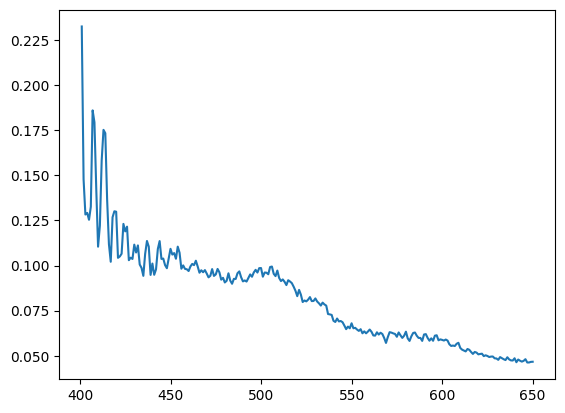

In [154]:
ratio=sipm/nist

mask = wavelength > 400
wavelength_filtered = wavelength[mask]
ratio_filtered=ratio[mask]

plt.plot(wavelength_filtered,ratio_filtered)
plt.show()

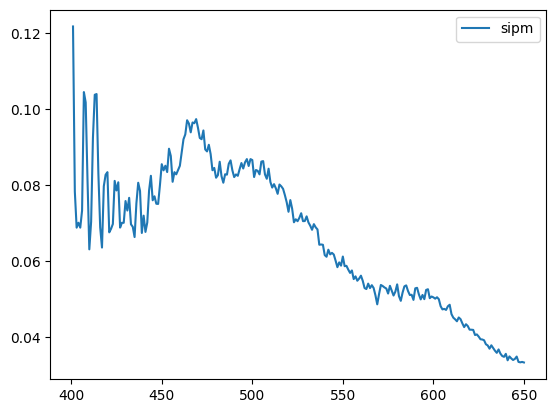

In [157]:
#SiPM plot

# Filter for wavelengths > 400 nm
mask = wavelength > 400
wavelength_filtered = wavelength[mask]
sipm_filtered = sipm[mask]
transmission_filtered = np.array(transmission)[mask]

# SiPM plot for wavelengths > 400 nm
plt.plot(wavelength_filtered, sipm_filtered, label="sipm")

plt.legend()
plt.show()